In [1]:
import numpy as np
import sys
import time
import h5py as h5
import matplotlib.pyplot as plt

sys.path.append(r"C:\Users\haoyuan\Documents\GitHub\CrystalDiff")

from CrystalDiff import util, pulse, lclsutil, groutine, crystal

# Get the Crystal Geometries

In [2]:
# ----------------------------------------------------------------------------------------------------------
#                       Step 1: Pulse
# ----------------------------------------------------------------------------------------------------------

energy_center = 10.
pre_length = 1e6

# Set up the pulse
my_pulse = pulse.GaussianPulse3D()
my_pulse.set_pulse_properties(central_energy=energy_center,
                              polar=[0., 1., 0.],
                              sigma_x=100.,
                              sigma_y=100.,
                              sigma_z=1.,
                              x0=np.array([0., 0., -pre_length]))

# ----------------------------------------------------------------------------------------------------------
#                       Step 2: Split
# ----------------------------------------------------------------------------------------------------------
dtheta = np.arctan(1.5 * 1e-3 / 5.)      # This is the deviation angle.

grating_list = [crystal.RectangleGrating(), crystal.RectangleGrating()]
grating_list[0].set_a(util.get_grating_period(dtheta=dtheta, klen_in=my_pulse.klen0) / 2)
grating_list[0].set_b(util.get_grating_period(dtheta=dtheta, klen_in=my_pulse.klen0) / 2)

grating_list[1].set_a(util.get_grating_period(dtheta=dtheta, klen_in=my_pulse.klen0) / 2)
grating_list[1].set_b(util.get_grating_period(dtheta=dtheta, klen_in=my_pulse.klen0) / 2)

# ----------------------------------------------------------------------------------------------------------
#                       Step 3: Delay Lines
# ----------------------------------------------------------------------------------------------------------
# Some meta data for the delay line.
reflect_num = 4
h_length = 2. * np.pi / (1.9201 * 1e-4)
hlen_vals = np.array([h_length, ] * reflect_num)

# Some crystal properties
chi0=complex(-0.97631E-05, 0.14871E-06)
chih_sigma=complex(0.59310E-05, -0.14320E-06)
chihbar_sigma=complex(0.59310E-05, -0.14320E-06)
chih_pi=complex(0.46945E-05, -0.11201E-06)
chihbar_pi=complex(0.46945E-05, -0.11201E-06)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                       Crystal for branch  1
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Set up the angles
angle_offset_1 = dtheta
bragg_angle_1 = np.radians(18.836) + 13e-6

branch_angle_1 = lclsutil.get_delay_line_angles(angle_offset=angle_offset_1,
                                                theta=bragg_angle_1 + np.pi / 2. ,
                                                rho=bragg_angle_1 - np.pi / 2. ,
                                                inclined_angle=np.radians(10.))
surface_points_1 = np.zeros((reflect_num, 3), dtype=np.float64)

# Initialize the crystals
crystal_list_1 = lclsutil.get_crystal_list(num=reflect_num,
                                           hlen_vals=hlen_vals,
                                           theta_vals=branch_angle_1[0],
                                           rho_vals=branch_angle_1[1],
                                           tau_vals=branch_angle_1[2],
                                           surface_points=surface_points_1,
                                           chi0=chi0,
                                           chih_sigma=chih_sigma, chihbar_sigma=chihbar_sigma,
                                           chih_pi=chih_pi, chihbar_pi=chihbar_pi)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                       Crystal for branch  2
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Set up the angles
angle_offset_2 = - dtheta
bragg_angle_2 = np.radians(18.836) + 13e-6

branch_angle_2 = lclsutil.get_delay_line_angles(angle_offset=angle_offset_2,
                                                theta=1.5 * np.pi - bragg_angle_2,
                                                rho=0.5 * np.pi - bragg_angle_2,
                                                inclined_angle=np.radians(0.))
surface_points_2 = np.zeros((reflect_num, 3), dtype=np.float64)

# Initialize the crystals
crystal_list_2 = lclsutil.get_crystal_list(num=reflect_num,
                                           hlen_vals=hlen_vals,
                                           theta_vals=branch_angle_2[0],
                                           rho_vals=branch_angle_2[1],
                                           tau_vals=branch_angle_2[2],
                                           surface_points=surface_points_2,
                                           chi0=chi0,
                                           chih_sigma=chih_sigma, chihbar_sigma=chihbar_sigma,
                                           chih_pi=chih_pi, chihbar_pi=chihbar_pi)


# ------------------------------------------------------
#   Define the positions
# ------------------------------------------------------
path_list_1 = [5e6 - 10e4, 1e5, 5e5,
               1.05e5, 6e6, 1e6]
path_list_2 = [5e6, 1e5, 1e5,
               1.05e5, 6e6, 1e6]
delay_time = 0.

The total propagation length is 12.23m.


# Arrange the crystals for each branch

In [ ]:
# Adjust the path sections
(path_list_1,
 path_list_2) = lclsutil.get_split_delay_configuration(delay_time=delay_time,
                                                       fix_branch_path = path_list_2, 
                                                       var_branch_path= path_list_1,
                                                       fix_branch_crystal = crystal_list_2, 
                                                       var_branch_crystal = crystal_list_1,
                                                       grating_pair=grating_list,
                                                       pulse_obj=my_pulse)

(intersect_brunch_1,
 kout_brunch_1,
 intersect_brunch_2,
 kout_brunch_2) = lclsutil.get_light_path(pulse_obj=my_pulse,
                                          grating_list=grating_list,
                                          crystal_list_1=crystal_list_1,
                                          path_list_1=path_list_1,
                                          crystal_list_2=crystal_list_2,
                                          path_list_2=path_list_2)

# Initialize the crystals
crystal_list_1 = lclsutil.get_crystal_list(num=reflect_num,
                                           hlen_vals=hlen_vals,
                                           theta_vals=branch_angle_1[0],
                                           rho_vals=branch_angle_1[1],
                                           tau_vals=branch_angle_1[2],
                                           surface_points=np.copy(intersect_brunch_1[1:5]),
                                           chi0=chi0,
                                           chih_sigma=chih_sigma, chihbar_sigma=chihbar_sigma,
                                           chih_pi=chih_pi, chihbar_pi=chihbar_pi)

# Initialize the crystals
crystal_list_2 = lclsutil.get_crystal_list(num=reflect_num,
                                           hlen_vals=hlen_vals,
                                           theta_vals=branch_angle_2[0],
                                           rho_vals=branch_angle_2[1],
                                           tau_vals=branch_angle_2[2],
                                           surface_points=np.copy(intersect_brunch_2[1:5]),
                                           chi0=chi0,
                                           chih_sigma=chih_sigma, chihbar_sigma=chihbar_sigma,
                                           chih_pi=chih_pi, chihbar_pi=chihbar_pi)

grating_list[0].set_surface_point(np.copy(intersect_brunch_1[0]))
grating_list[1].set_surface_point(np.copy(intersect_brunch_1[-2]))


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Get the observation point
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
observation = np.copy(intersect_brunch_2[-1])

total_path = pre_length + util.get_total_path_length(intersection_point_list=intersect_brunch_2)
print("The total propagation length is {:.2f}m.".format(total_path/1e6))
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                  Change frame
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#"""
(my_pulse, 
 crystal_list_1,
 crystal_list_2,
 grating_list, 
 obvservation)= lclsutil.get_split_delay_output_frame(displacement=-np.copy(intersect_brunch_1[-2]),
                                                       obvservation=observation,
                                                       pulse=my_pulse,
                                                       crystal_list_1=crystal_list_1,
                                                       crystal_list_2=crystal_list_2,
                                                       grating_pair=grating_list)
#"""
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                  Get the momentum mesh
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
number_x = 2
number_y = 500
number_z = 10 ** 5
kx_grid, ky_grid, kz_grid, axis_info = lclsutil.get_k_mesh_3d(number_x=number_x,
                                                              number_y=number_y,
                                                              number_z=number_z,
                                                              delta_e_x=1e-50,
                                                              delta_e_y=3e-4,
                                                              delta_e_z=3e-4 / util.c)
kz_grid += my_pulse.klen0

# Apply fft shift
#kx_grid = np.ascontiguousarray(np.fft.fftshift(kx_grid))
kx_grid = np.zeros(1, np.float64)
number_x = 1
ky_grid = np.ascontiguousarray(np.fft.fftshift(ky_grid))
kz_grid = np.ascontiguousarray(np.fft.fftshift(kz_grid))

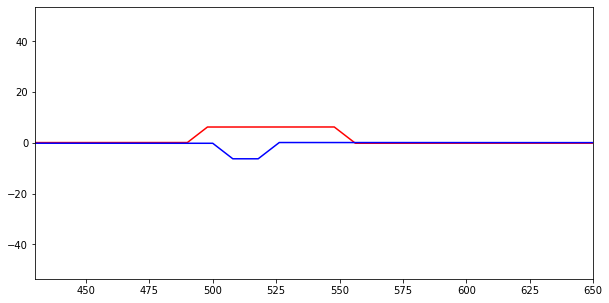

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

axes.plot(intersect_brunch_1[:,2]/1e4, intersect_brunch_1[:,1]/1e4,'r')
axes.plot(intersect_brunch_2[:,2]/1e4, intersect_brunch_2[:,1]/1e4,'b')

axes.set_xlim([5e2-70, 5e2 + 150])
axes.set_ylim([-0.1, 0.1])
axes.set_aspect('equal', 'datalim')

plt.show()

In [5]:
# Set the range of the index to save
z_idx_range = 500
num1 = 450
num2 = 50
d_num = 512

# -------------------------------------------------------------
#            Get Field for Branch 1
# -------------------------------------------------------------
tic = time.time()

(result_3d_dict_1,
 result_2d_dict_1,
 check_dict_1) = groutine.get_single_branch_split_delay_field(grating_pair = grating_list,
                                                            channel_cuts = crystal_list_1,
                                                            total_path = total_path, 
                                                            observation = observation,
                                                            my_pulse = my_pulse,
                                                            kx_grid = kx_grid,
                                                            ky_grid = ky_grid,
                                                            kz_grid = kz_grid,
                                                            delay_time = 0.,
                                                            grating_orders = [1., -1.],
                                                            number_x = number_x,
                                                            number_y = number_y,
                                                            number_z = number_z,
                                                            z_idx_range = z_idx_range,
                                                            num1 = num1,
                                                            num2 = num2, 
                                                            d_num = 512)

toc = time.time()
print("It takes {:.2f} seconds to get the field for branch 1.".format(toc - tic))

# -------------------------------------------------------------
#            Get Field for Branch 2
# -------------------------------------------------------------
tic = time.time()

(result_3d_dict_2,
 result_2d_dict_2,
 check_dict_2) = groutine.get_single_branch_split_delay_field(grating_pair = grating_list,
                                                            channel_cuts = crystal_list_2,
                                                            total_path = total_path, 
                                                            observation = observation,
                                                            my_pulse = my_pulse,
                                                            kx_grid = kx_grid,
                                                            ky_grid = ky_grid,
                                                            kz_grid = kz_grid,
                                                            delay_time = 0.,
                                                            grating_orders = [-1., 1.],
                                                            number_x = number_x,
                                                            number_y = number_y,
                                                            number_z = number_z,
                                                            z_idx_range = z_idx_range,
                                                            num1 = num1,
                                                            num2 = num2, 
                                                            d_num = 512)

toc = time.time()
print("It takes {:.2f} seconds to get the field for branch 2.".format(toc - tic))

It takes 0.06 seconds to prepare the variables.
It takes 25.36 seconds to get the field for branch 1.
It takes 0.05 seconds to prepare the variables.
It takes 24.80 seconds to get the field for branch 2.


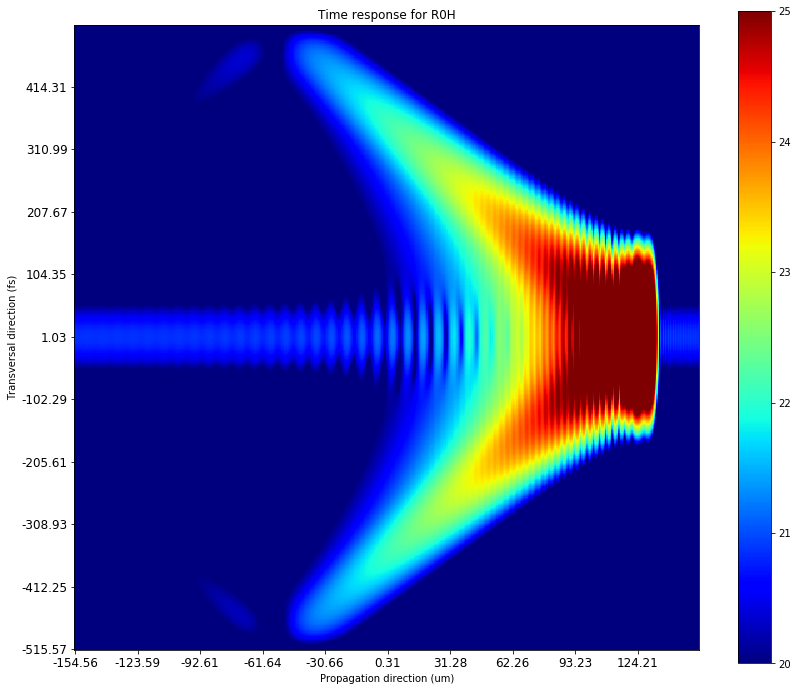

In [6]:
# Set up the canvas
fig, axes = plt.subplots(nrows=1, ncols=1)
fig.set_figheight(12)
fig.set_figwidth(14)

ratio = (((axis_info['z_idx'][z_idx_range - 1] - axis_info['z_idx'][0]) /z_idx_range) /
         ((axis_info['y_idx'][-1] - axis_info['y_idx'][0]) / number_y))

field_1 = np.fft.ifftshift(np.fft.ifft(result_2d_dict_1['y_field_2d'], axis=0), axes=0)

im = axes.imshow(np.log(np.abs( field_1 )),
                 vmin=  20,
                 vmax = 25.,
                 cmap='jet', 
                 origin='lower',
                 #aspect = 1/util.c,
                 )

axes.set_title("Time response for R0H")
axes.set_yticks(np.arange(0, number_y, step=50))
axes.set_yticklabels(axis_info["y_idx_tick"][::50], fontsize=12)
axes.set_xticks(np.arange(0, z_idx_range, step=50))
axes.set_xticklabels(axis_info["z_idx_tick"][number_z//2 - z_idx_range//2:
                                              number_z//2 + z_idx_range//2:50], fontsize=12)

axes.set_xlabel("Propagation direction (um)")
axes.set_ylabel("Transversal direction (fs)")
fig.colorbar(im, ax=axes)
# Show the canvas

plt.show()

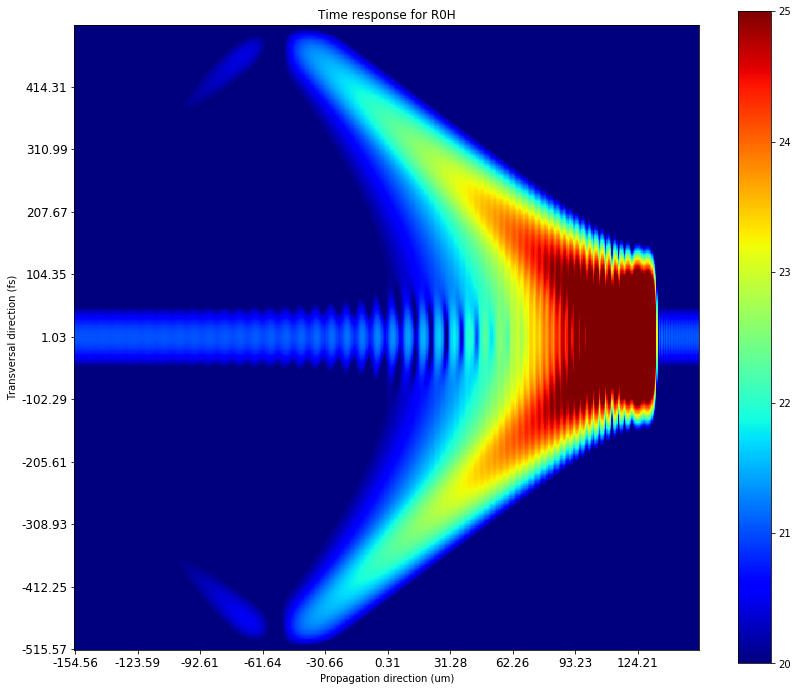

In [7]:
# Set up the canvas
fig, axes = plt.subplots(nrows=1, ncols=1)
fig.set_figheight(12)
fig.set_figwidth(14)

ratio = (((axis_info['z_idx'][z_idx_range - 1] - axis_info['z_idx'][0]) /z_idx_range) /
         ((axis_info['y_idx'][-1] - axis_info['y_idx'][0]) / number_y))

field_2 = np.fft.ifftshift(np.fft.ifft(result_2d_dict_2['y_field_2d'], axis=0), axes=0)

im = axes.imshow(np.log(np.abs(field_2)),
                 vmin=  20,
                 vmax = 25.,
                 cmap='jet', 
                 origin='lower',
                 #aspect = 1/util.c,
                 )

axes.set_title("Time response for R0H")
axes.set_yticks(np.arange(0, number_y, step=50))
axes.set_yticklabels(axis_info["y_idx_tick"][::50], fontsize=12)
axes.set_xticks(np.arange(0, z_idx_range, step=50))
axes.set_xticklabels(axis_info["z_idx_tick"][number_z//2 - z_idx_range//2:
                                              number_z//2 + z_idx_range//2:50], fontsize=12)

axes.set_xlabel("Propagation direction (um)")
axes.set_ylabel("Transversal direction (fs)")
fig.colorbar(im, ax=axes)
# Show the canvas

plt.show()

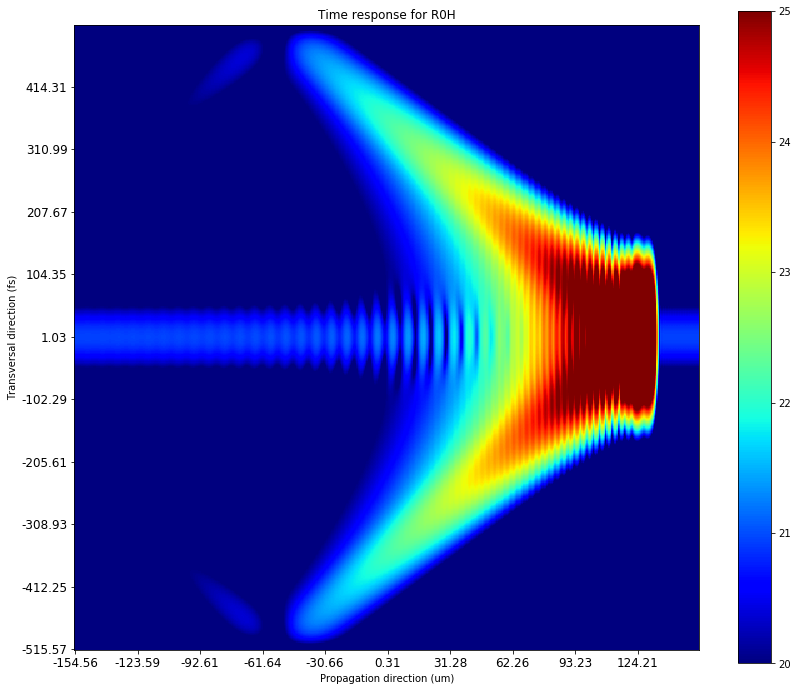

In [8]:
# Set up the canvas
fig, axes = plt.subplots(nrows=1, ncols=1)
fig.set_figheight(12)
fig.set_figwidth(14)


im = axes.imshow(np.log(np.abs( field_1 + field_2 )) - np.log(2.),
                 vmin=  20,
                 vmax = 25.,
                 cmap='jet', 
                 origin='lower',
                 #aspect = 1/util.c,
                 )

axes.set_title("Time response for R0H")
axes.set_yticks(np.arange(0, number_y, step=50))
axes.set_yticklabels(axis_info["y_idx_tick"][::50], fontsize=12)
axes.set_xticks(np.arange(0, z_idx_range, step=50))
axes.set_xticklabels(axis_info["z_idx_tick"][number_z//2 - z_idx_range//2:
                                              number_z//2 + z_idx_range//2:50], fontsize=12)

axes.set_xlabel("Propagation direction (um)")
axes.set_ylabel("Transversal direction (fs)")
fig.colorbar(im, ax=axes)
# Show the canvas

plt.show()

In [11]:
import scipy.spatial as ss

In [13]:
ss.__all__

['ConvexHull',
 'Delaunay',
 'HalfspaceIntersection',
 'KDTree',
 'Rectangle',
 'SphericalVoronoi',
 'Voronoi',
 'absolute_import',
 'cKDTree',
 'ckdtree',
 'convex_hull_plot_2d',
 'delaunay_plot_2d',
 'distance',
 'distance_matrix',
 'division',
 'kdtree',
 'minkowski_distance',
 'minkowski_distance_p',
 'print_function',
 'procrustes',
 'qhull',
 'tsearch',
 'voronoi_plot_2d',
 'distance']